### Analysis of an exponential growth model 

Exponential growth, $Q(t) = Q_o*exp(t/T_o)$, is often encountered in
simple systems. In this case, the growth time (the inverse of the more 
common growth rate), $T = [d(lnQ)/dt]^{-1}$, is constant ($T=T_o$). 

Following Elitzur (1995), complex systems can be analyzed by expanding
$T$ into a Taylor series of Q:
$$
   T(Q) = T_o + \sum_{n=1}^\infty a_n Q^n.
$$

Given $a_n$, the implied model for $Q(t)$ is given by the implicit 
relationship
$$
 ln(Q/Q_o) + \sum_{n=1}^\infty {a_n \over n} (Q^n - Q_o^n) = {t \over T_o}.
$$

Here we use the U.S. gross domestic product data for years 1791-2017 
as $Q(t)$, and explore how the model fit to $Q(t)$ improves with the 
number of retained terms in the Taylor expansion of $T(Q)$.

 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [2]:
### read data
data = np.loadtxt('GDP_US.dat', usecols=(0, 1), unpack=True) 
## the U.S. gross domestic product for years 1791-2017 
gdp = data[0]
Ndata = gdp.size
# we need to generate time array 
t = np.linspace(0,Ndata-1,Ndata)
firstYear = 1791
# years for plotting 
year = firstYear + t 
# data is normalized so that 
Qo = 1.0 
## and a model based on 2-term T(Q) expansion from Moshe Elitzur
model2me = data[1] 
# we don't have errors for data (gdp); let's **assume** a simple
# error model proportional to the data value plus a systematic term
sysErr = 0.2
fracErr = 0.16
gdpErr = sysErr + fracErr * gdp 

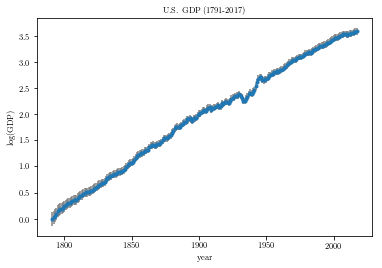

In [3]:
# let's plot GDP(time) (log-lin scale)
Lgdp = np.log10(gdp)
LgdpErr = np.log10(1+gdpErr/gdp)
# plot 
fig, ax = plt.subplots()
ax.errorbar(year, Lgdp, LgdpErr, fmt='.', ecolor='gray')
ax.set(xlabel='year', ylabel='log(GDP)', title='U.S. GDP (1791-2017)')

In [4]:
# qiven t and Q, T(Q) = 1/[d(lnQ)/dt] 
def getGrowthTime(t, Q, type=1):
    if (type):
        lnQ = np.log(Q)
        # smooth lnQ with Savitzky-Golay filter
        from astroML.filters import savitzky_golay
        lnQsg = savitzky_golay(lnQ, window_size=11, order=2, use_fft=False)
        dlnQdt = np.gradient(lnQsg, t, edge_order=2) 
    else:
        dQdt = np.gradient(Q, t, edge_order=2) 
        dlnQdt = dQdt / Q
        
    return 1.0/dlnQdt 

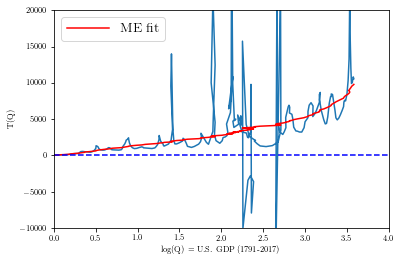

In [5]:
# let's plot T(Q)
T = getGrowthTime(t,gdp)
# model T 
Tme = getGrowthTime(t,model2me)

# plot 
fig, ax = plt.subplots()
ax.plot(Lgdp, T)
ax.plot(Lgdp, Tme, 'r', label='ME fit')
ax.set(xlabel='log(Q) = U.S. GDP (1791-2017)', ylabel='T(Q)')
ax.set_xlim(0, 4.0)
ax.set_ylim(-10000, 20000)
ax.plot([0,10], [0.0, 0.0], '--', c='blue')
ax.legend(loc='best', fontsize=14)

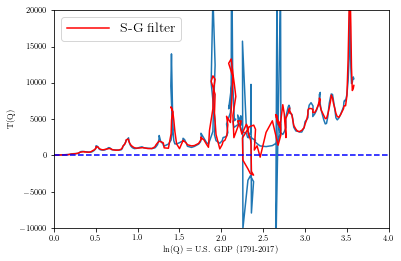

In [6]:
# smooth noise with Savitzky-Golay filter
from astroML.filters import savitzky_golay
Tsg = savitzky_golay(T, window_size=11, order=3, use_fft=False)

# plot 
fig, ax = plt.subplots()
ax.plot(Lgdp, T)
ax.plot(Lgdp, Tsg,'r', label='S-G filter')
ax.set(xlabel='ln(Q) = U.S. GDP (1791-2017)', ylabel='T(Q)')
ax.set_xlim(0, 4.0)
ax.set_ylim(-10000, 20000)
ax.plot([0,10], [0.0, 0.0], '--', c='blue')
ax.legend(loc='best', fontsize=14)

In [7]:
## polynomial fitting tools 
from scipy import optimize
# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

CHI2:
   best linear model: 29951.6126263
best quadratic model: 29142.9287281
CHI2 per degree of freedom:
   best linear model: 293.643261042
best quadratic model: 288.543848793


(-10000, 20000)

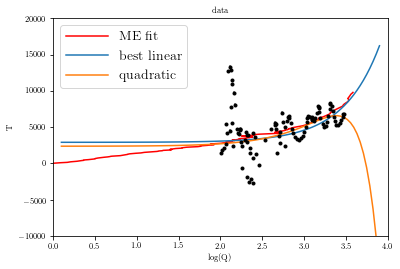

In [8]:
## fit T(Q) with polynomials
# the fitting range 
gdpMin = 100
gdpMax = 3000
mask = (gdp>gdpMin) & (gdp<gdpMax)
gdpok = gdp[mask]   
Lgdpok = Lgdp[mask]   
Ndataok = gdpok.size
if (0):
    # no smoothing    
    Tok = T[mask]  
    # test reproducibility of Moshe's fit
    Tok = Tme[mask]  
else:
    # smoothed with Savitzky-Golay filter
    Tok = Tsg[mask]  

# a problem: what is error for T? 
# ansatz for now: constant 1% error plus systematic error
Terrok = 0.01*np.abs(Tok) + 100
data = gdpok, Tok, Terrok

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
#theta3 = best_theta(3, data=data)

# generate best fit lines on a fine grid 
Lxfit = np.linspace(0.1, 3.9, 100)
xfit = np.power(10,Lxfit)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
#yfit3 = polynomial_fit(theta3, xfit)

# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((Tok-polynomial_fit(theta1, gdpok))/Terrok)**2) 
chi22 = np.sum(((Tok-polynomial_fit(theta2, gdpok))/Terrok)**2) 
#chi23 = np.sum(((Tok-polynomial_fit(theta3, gdpok))/Terrok)**2) 

# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndataok - 2)
chi2dof2 = chi22/(Ndataok - 3)
#chi2dof3 = chi23/(Ndataok - 4)

print "CHI2:"
print '   best linear model:', chi21
print 'best quadratic model:', chi22
#print '    best cubic model:', chi23
print "CHI2 per degree of freedom:"
print '   best linear model:', chi2dof1
print 'best quadratic model:', chi2dof2
#print '    best cubic model:', chi2dof3

# plot 
fig, ax = plt.subplots()
ax.errorbar(Lgdpok, Tok, Terrok, fmt='.k', ecolor='gray')
ax.plot(Lgdp, Tme, 'r', label='ME fit')
ax.plot(Lxfit, polynomial_fit(theta1, xfit), label='best linear')
ax.plot(Lxfit, polynomial_fit(theta2, xfit), label='quadratic')
#ax.plot(Lxfit, polynomial_fit(theta3, xfit), label='best cubic')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='log(Q)', ylabel='T', title='data');
ax.set_xlim(0, 4.0)
ax.set_ylim(-10000, 20000)
#ax.plot([0,10], [0.0, 0.0], '--', c='blue')

(-10000, 20000)

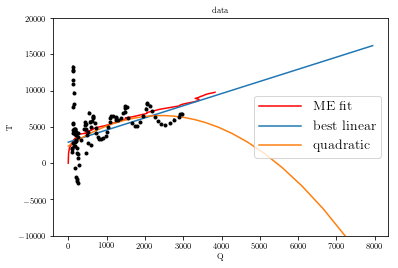

In [9]:

# plot 
fig, ax = plt.subplots()
ax.errorbar(gdpok, Tok, Terrok, fmt='.k', ecolor='gray')
ax.plot(gdp, Tme, 'r', label='ME fit')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='quadratic')
#ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='Q', ylabel='T', title='data');
#ax.set_xlim(0, 4.0)
ax.set_ylim(-10000, 20000)
#ax.plot([0,10], [0.0, 0.0], '--', c='blue')
 

### Analysis of an exponential growth model 

Now we will use the world population data for years 1950-2015. 

In [10]:
### read data (population in thousands)
data = np.loadtxt('World_POP.dat', usecols=(0, 1), unpack=True) 
year = data[0]
# change units to "million people"
wp = data[1]/1000.0 
yearMax = 2100
wp = wp[year<yearMax]
year = year[year<yearMax]
Ndata = wp.size
# we don't have errors for data; let's **assume** a simple
# error model proportional to the data value plus a systematic term
sysErr = 1.0 
fracErr = 0.01
wpErr = sysErr + fracErr * wp 

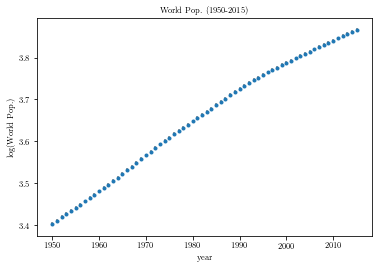

In [11]:
# let's plot Pop(time) (log-lin scale)
Lwp = np.log10(wp)
LwpErr = np.log10(1+wpErr/wp)
# plot 
fig, ax = plt.subplots()
ax.errorbar(year, Lwp, LwpErr, fmt='.', ecolor='gray')
ax.set(xlabel='year', ylabel='log(World Pop.)', title='World Pop. (1950-2015)')

In [12]:
# qiven t and Q, T(Q) = 1/[d(lnQ)/dt] 
def getGrowthTime2(t, Q):
    dQdt = 0*Q
    for i in range(0, Q.size-1):
        dQdt[i] = (Q[i+1]-Q[i])/(t[i+1]-t[i])
    dlnQdt = dQdt / Q  
    dlnQdt[Q.size-1] = dlnQdt[Q.size-2] 
    return 1.0/dlnQdt 

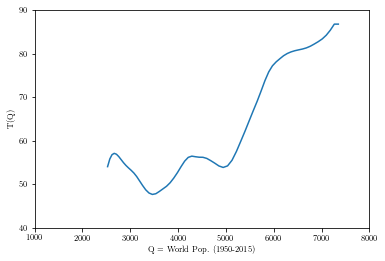

In [13]:
# let's plot T(Q)
time = year - year[0]
T = getGrowthTime2(time, wp)
# plot 
fig, ax = plt.subplots()
ax.plot(wp, T)
ax.set(xlabel='Q = World Pop. (1950-2015)', ylabel='T(Q)')
ax.set_xlim(1000, 8000)
ax.set_ylim(40, 90)
ax.legend(loc='best', fontsize=14)

In [14]:
# a problem: what is error for T? 
# ansatz for now: constant 1% error plus systematic error
Terr = 0.01*np.abs(T) + 0.1
data = wp, T, Terr

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)

# generate best fit lines on a fine grid 
xfit = np.linspace(2000, 8000, 100)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)

# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((T-polynomial_fit(theta1, wp))/Terr)**2) 
chi22 = np.sum(((T-polynomial_fit(theta2, wp))/Terr)**2) 

# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
 
print "CHI2:"
print '   best linear model:', chi21
print 'best quadratic model:', chi22
print "CHI2 per degree of freedom:"
print '   best linear model:', chi2dof1
print 'best quadratic model:', chi2dof2 

CHI2:
   best linear model: 4675.90343221
best quadratic model: 2340.74966423
CHI2 per degree of freedom:
   best linear model: 73.0609911283
best quadratic model: 37.1547565751


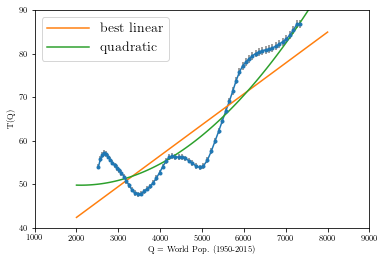

In [15]:
# plot 
fig, ax = plt.subplots()
ax.plot(wp, T)
ax.errorbar(wp, T, Terr, fmt='.', ecolor='gray')

ax.set(xlabel='Q = World Pop. (1950-2015)', ylabel='T(Q)')
ax.set_xlim(1000, 9000)
ax.set_ylim(40, 90)
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='quadratic')
ax.legend(loc='best', fontsize=14) 

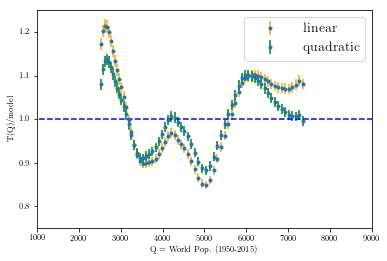

In [16]:
# residuals
rat1 = T / polynomial_fit(theta1, wp) 
rat1err = Terr / polynomial_fit(theta1, wp) 
rat2 = T / polynomial_fit(theta2, wp) 
rat2err = Terr / polynomial_fit(theta2, wp) 

# plot 
fig, ax = plt.subplots()
ax.errorbar(wp, rat1, rat1err, fmt='.', ecolor='orange', label='linear')
ax.errorbar(wp, rat2, rat2err, fmt='.', ecolor='green', label='quadratic')

ax.set(xlabel='Q = World Pop. (1950-2015)', ylabel='T(Q)/model')
ax.set_xlim(1000, 9000)
ax.set_ylim(0.75, 1.25)
ax.legend(loc='best', fontsize=14)
ax.plot([0,10000], [1.0, 1.0], '--', c='blue')

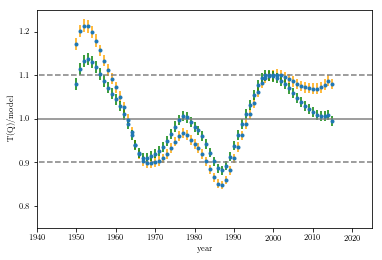

In [17]:
# 2nd-order residuals oscillate as a function of Q
# do we see these oscillations as a function of time? 
# plot 
fig, ax = plt.subplots()
ax.errorbar(year, rat1, rat1err, fmt='.', ecolor='orange')
ax.errorbar(year, rat2, rat2err, fmt='.', ecolor='green')

ax.set(xlabel='year', ylabel='T(Q)/model')
ax.set_xlim(1940, 2025)
ax.set_ylim(0.75, 1.25)
ax.legend(loc='best', fontsize=14)
ax.plot([0,10000], [1.0, 1.0], '-', c='gray')
ax.plot([0,10000], [0.9, 0.9], '--', c='gray')
ax.plot([0,10000], [1.1, 1.1], '--', c='gray')

In [18]:
# given the coefficients of the polynomial fit to T(Q), and Qfit array, 
# return the corresponding vector of tfit so that Qmodel = Qfit(tfit)
def getTimefromGrowthTimeFit(Qfit, theta):
    T0 = theta[0]
    Q0 = Qfit[0]
    tfit = np.log(Qfit/Q0)
    for i in range(1,theta.size):
        tfit += theta[i]/i * (np.power(Qfit,i)-np.power(Q0,i)) / T0
    # renormalize 
    return tfit*T0

In [19]:
# compare models to data
logQfit = np.linspace(3.4, 4.00, 3600)
Qfit = np.power(10,logQfit)
theta0 = best_theta(0, data=data)
tfit00 = getTimefromGrowthTimeFit(Qfit,theta0)
tfit0 = tfit00 + year[0] 
tfit10 = getTimefromGrowthTimeFit(Qfit,theta1)
tfit1 = tfit10 + year[0] 
tfit20 = getTimefromGrowthTimeFit(Qfit,theta2)
tfit2 = tfit20 + year[0] 

2042.10492028
2048.00701788
7385.71524224
7375.22124597
7848.58993209
7793.2709763
9788.44695468
9394.91896811


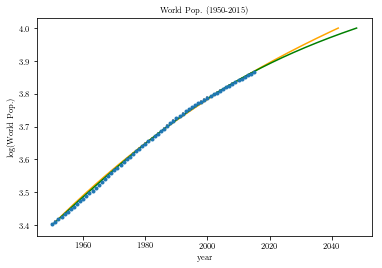

In [20]:
# plot
fig, ax = plt.subplots()
ax.errorbar(year, Lwp, LwpErr, fmt='.', ecolor='gray')
ax.plot(tfit1, logQfit, 'orange')
ax.plot(tfit2, logQfit, 'green')
ax.set(xlabel='year', ylabel='log(World Pop.)', title='World Pop. (1950-2015)')
print np.max(tfit1)
print np.max(tfit2)
print np.interp(2015, tfit1, Qfit)
print np.interp(2015, tfit2, Qfit)
print np.interp(2020, tfit1, Qfit)
print np.interp(2020, tfit2, Qfit)
print np.interp(2040, tfit1, Qfit)
print np.interp(2040, tfit2, Qfit) 

(0.96, 1.04)

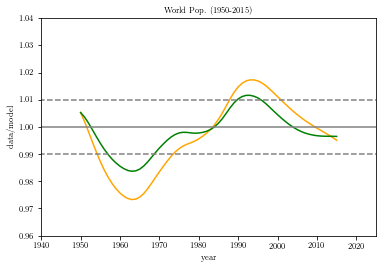

In [21]:
## plot data/model ratios 
# we need to interpolate Qfit(tfit1) to year grid
model1 = np.interp(year, tfit1, Qfit)
dmrat1 = wp / model1
model2 = np.interp(year, tfit2, Qfit)
dmrat2 = wp / model2 
# plot
fig, ax = plt.subplots()
ax.plot(year, dmrat1, 'orange')
ax.plot(year, dmrat2, 'green')
ax.set(xlabel='year', ylabel='data/model', title='World Pop. (1950-2015)')
ax.plot([0,10000], [1.0, 1.0], '-', c='gray')
ax.plot([0,10000], [0.99, 0.99], '--', c='gray')
ax.plot([0,10000], [1.01, 1.01], '--', c='gray')
ax.set_xlim(1940, 2025)
ax.set_ylim(0.96, 1.04)

In [22]:
print np.std(dmrat1)
print np.std(dmrat2)

0.0132075549175
0.00766779732826
